In [24]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
seaborn.set()
data = pd.read_csv("data/train_data.csv")
X_train = data[data.ScheduleTime < '2022-02-01'].drop(["ScheduleTime", "LoadFactor"], axis = 1)
y_train = data[data.ScheduleTime < '2022-02-01'].LoadFactor.values

X_test  = data[data.ScheduleTime >= '2022-02-01'].drop(["ScheduleTime", "LoadFactor"], axis = 1)
y_test  = data[data.ScheduleTime >= '2022-02-01'].LoadFactor.values

SeatCapacity = X_test.SeatCapacity.values

In [25]:
Forest  = RandomForestRegressor(n_estimators = 25, min_samples_leaf = 2, max_features = 10, n_jobs= -1)
Booster = GradientBoostingRegressor(n_estimators = 900, max_depth = 7, learning_rate = 0.022357, max_features = 10, subsample = .5)

Forest.fit(X_train, y_train)
Booster.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.022357, max_depth=7, max_features=10,
                          n_estimators=900, subsample=0.5)

# Random Forest 

In [26]:
N = 5000

In [27]:
y_hat = Forest.predict(X_test)

M = len(y_test)

Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

MSE_bootstrap = pow(y_hat[Bootstrap_idx] - y_test[Bootstrap_idx],2).mean(0)
Forest_MSE = MSE_bootstrap.mean()
Forest_MSE_CI  = np.quantile(MSE_bootstrap, q = [0.025, 0.975])
print(f"Mean Squared Error (Test): {round(Forest_MSE,5)}")
print(f"Bootstrapped CI's MSE (Test): {np.round(Forest_MSE_CI,5)}")


Mean Squared Error (Test): 0.04009
Bootstrapped CI's MSE (Test): [0.03851 0.04167]


In [28]:
y_hat_no_zero = y_hat[y_test != 0]
y_test_no_zero = y_test[y_test != 0]


M = len(y_test_no_zero)

Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

ActualPassengers    = SeatCapacity[y_test != 0] * y_test_no_zero
PredictedPassengers = SeatCapacity[y_test != 0] * y_hat_no_zero 

PassengerScore_bootstrap = (1 - abs((ActualPassengers[Bootstrap_idx] - PredictedPassengers[Bootstrap_idx]) / (ActualPassengers[Bootstrap_idx]))).mean(axis = 0)
Forest_PassengerScore           = PassengerScore_bootstrap.mean()

Forest_PassengerScore_CI = np.quantile(PassengerScore_bootstrap, [0.025, 0.975])
print(f"Passenger Deviance (Test): {round(Forest_PassengerScore,5)}")
print(f"Bootstrapped CI's Passeneger Deviance (Test): {np.round(Forest_PassengerScore_CI,5)}")

Passenger Deviance (Test): 0.4822
Bootstrapped CI's Passeneger Deviance (Test): [0.44299 0.51865]


# Gradient Booster

In [29]:
y_hat = Booster.predict(X_test)

M = len(y_test)


Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

MSE_bootstrap = pow(y_hat[Bootstrap_idx] - y_test[Bootstrap_idx],2).mean(0)
Booster_MSE = MSE_bootstrap.mean()
Booster_MSE_CI  = np.quantile(MSE_bootstrap, q = [0.025, 0.975])
print(f"Mean Squared Error (Test): {round(Booster_MSE,5)}")
print(f"Bootstrapped CI's MSE (Test): {np.round(Booster_MSE_CI,5)}")


Mean Squared Error (Test): 0.03854
Bootstrapped CI's MSE (Test): [0.03694 0.04003]


In [30]:
y_hat_no_zero = y_hat[y_test != 0]
y_test_no_zero = y_test[y_test != 0]


M = len(y_test_no_zero)


Bootstrap_idx = np.random.choice(np.arange(M), (M, 1000), replace=True)

ActualPassengers    = SeatCapacity[y_test != 0] * y_test_no_zero
PredictedPassengers = SeatCapacity[y_test != 0] * y_hat_no_zero 

PassengerScore_bootstrap = (1 - abs((ActualPassengers[Bootstrap_idx] - PredictedPassengers[Bootstrap_idx]) / (ActualPassengers[Bootstrap_idx]))).mean(axis = 0)
Booster_PassengerScore           = PassengerScore_bootstrap.mean()

Booster_PassengerScore_CI = np.quantile(PassengerScore_bootstrap, [0.025, 0.975])
print(f"Passenger Deviance (Test): {round(Booster_PassengerScore,5)}")
print(f"Bootstrapped CI's Passeneger Deviance (Test): {np.round(Booster_PassengerScore_CI,5)}")


Passenger Deviance (Test): 0.53998
Bootstrapped CI's Passeneger Deviance (Test): [0.50782 0.5675 ]


# Plots

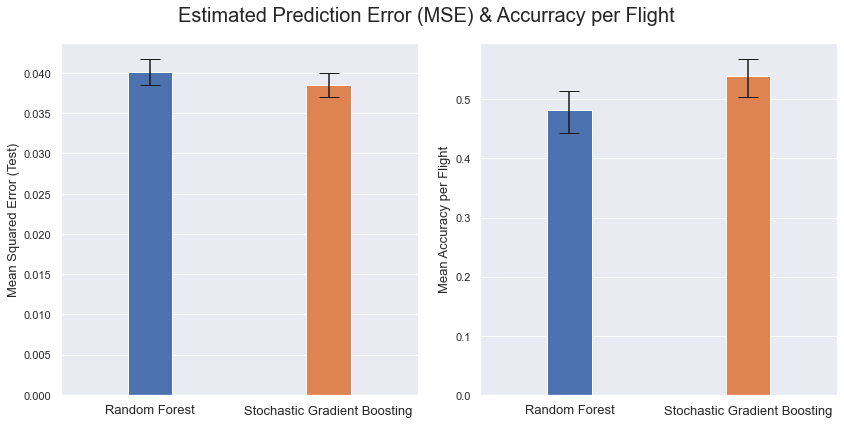

In [31]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].bar([-0.2, 0.2], [Forest_MSE, Booster_MSE],
         width = 0.1,
         color = ['C0', 'C1'],
         capsize = 10,
         yerr = np.array([abs(Forest_MSE - Forest_MSE_CI), abs(Booster_MSE - Booster_MSE_CI)]));

ax[0].set_xlim(-0.4, 0.4)
ax[0].set_xticks([-0.2, 0.2])
ax[0].set_xticklabels(["Random Forest", "Stochastic Gradient Boosting"], fontsize = 13)
ax[0].set_ylabel("Mean Squared Error (Test)", fontsize = 13)
ax[0].xaxis.grid(False)

ax[1].bar([-0.2, 0.2], [Forest_PassengerScore, Booster_PassengerScore],
         width = 0.1,
         color = ['C0', 'C1'],
         capsize = 10,
         yerr = np.array([abs(Forest_PassengerScore - Forest_PassengerScore_CI), abs(Booster_PassengerScore - Booster_PassengerScore_CI)]));
ax[1].set_xlim(-0.4, 0.4)
ax[1].set_xticks([-0.2, 0.2])
ax[1].set_xticklabels(["Random Forest", "Stochastic Gradient Boosting"],  fontsize = 13)
ax[1].set_ylabel("Mean Accuracy per Flight", fontsize = 13)
ax[1].xaxis.grid(False)
fig.suptitle("Estimated Prediction Error (MSE) & Accurracy per Flight", fontsize = 20)
fig.tight_layout()


# Predictions

In [32]:
final_model = GradientBoostingRegressor(n_estimators = 900, max_depth = 7, learning_rate = 0.022357, max_features = 10)

X = data.drop(["ScheduleTime","LoadFactor"], axis = 1)
y = data.LoadFactor

X.columns.shape

# final_model.fit(X,y)


(436,)

In [33]:
X_test = pd.read_csv("data/test_data.csv").drop(["ScheduleTime"], axis = 1)
LoadFactor = final_model.predict(X_test)

future_schedule = pd.read_excel('data/Future Schedule.xlsx')
future_schedule["LoadFactor"] = LoadFactor
future_schedule.to_csv("results/output.txt", index = False)
future_schedule

c:\Users\peter\OneDrive - Danmarks Tekniske Universitet\DTU\8. Semester\02582-Computational_Data_Analysis\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

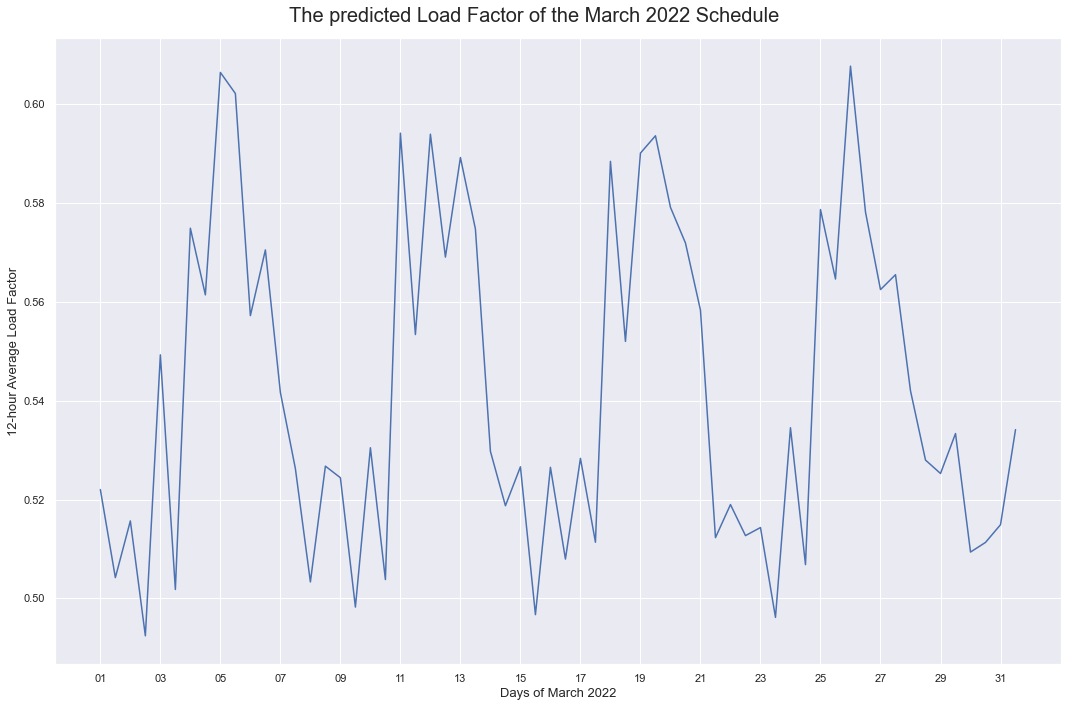

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
DailyLoad = future_schedule.set_index('ScheduleTime').resample('12h').mean()
# DailyLoad.LoadFactor.plot(ax = ax, );
ax.plot(DailyLoad.index, DailyLoad.LoadFactor)
ax.set_xticks(DailyLoad.index[::4])
ax.set_xticklabels(DailyLoad.reset_index().ScheduleTime[::4].apply(lambda x: x.strftime('%d')));
ax.set_xlabel("Days of March 2022", fontsize = 13)
ax.set_ylabel("12-hour Average Load Factor", fontsize = 13);
fig.suptitle("The predicted Load Factor of the March 2022 Schedule", fontsize = 20);
fig.tight_layout()
